In [58]:
import numpy as np
import os
import sys
import tarfile
import pickle
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mimage
%matplotlib inline 

from six.moves.urllib.request import urlretrieve

In [59]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '../input_data/notMnist/' # Change me to store data elsewhere

In [60]:
def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

In [61]:
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

In [62]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ../input_data/notMnist/notMNIST_large.tar.gz
Found and verified ../input_data/notMnist/notMNIST_small.tar.gz


In [63]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

In [64]:
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

../input_data/notMnist/notMNIST_large already present - Skipping extraction of ../input_data/notMnist/notMNIST_large.tar.gz.
['../input_data/notMnist/notMNIST_large/A', '../input_data/notMnist/notMNIST_large/B', '../input_data/notMnist/notMNIST_large/C', '../input_data/notMnist/notMNIST_large/D', '../input_data/notMnist/notMNIST_large/E', '../input_data/notMnist/notMNIST_large/F', '../input_data/notMnist/notMNIST_large/G', '../input_data/notMnist/notMNIST_large/H', '../input_data/notMnist/notMNIST_large/I', '../input_data/notMnist/notMNIST_large/J']
../input_data/notMnist/notMNIST_small already present - Skipping extraction of ../input_data/notMnist/notMNIST_small.tar.gz.
['../input_data/notMnist/notMNIST_small/A', '../input_data/notMnist/notMNIST_small/B', '../input_data/notMnist/notMNIST_small/C', '../input_data/notMnist/notMNIST_small/D', '../input_data/notMnist/notMNIST_small/E', '../input_data/notMnist/notMNIST_small/F', '../input_data/notMnist/notMNIST_small/G', '../input_data/no

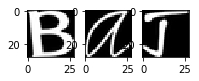

In [65]:
plt.figure(figsize=(5, 5))

plt.subplot(5, 5, 1)
fig = mimage.imread("../input_data/notMnist/notMNIST_large/B/Q0sgRXZvbHV0aW9uLnR0Zg==.png")
plt.imshow(fig, cmap="gray")

plt.subplot(5, 5, 2)
fig = mimage.imread("../input_data/notMnist/notMNIST_large/A/Q0sgU2NyaXB0LnR0Zg==.png")
plt.imshow(fig, cmap="gray")

plt.subplot(5, 5, 3)
fig = mimage.imread("../input_data/notMnist/notMNIST_large/J/Q0sgRm9ydHVuZS50dGY=.png")
plt.imshow(fig, cmap="gray")

plt.show()

In [66]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

In [67]:
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

In [68]:
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ../input_data/notMnist/notMNIST_large/A.pickle.
../input_data/notMnist/notMNIST_large/A
Could not read: ../input_data/notMnist/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ../input_data/notMnist/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ../input_data/notMnist/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825006
Standard deviation: 0.4431204
Pickling ../input_data/notMnist/notMNIST_large/B.pickle.
../input_data/notMnist/notMNIST_large/B
Could not read: ../input_data/notMnist/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full 